## Converting output files into a single csv file

In [1]:
import os,glob,imp
import pyslha
from importlib import import_module
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import alphashape
from descartes import PolygonPatch
import numpy as np
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})


In [2]:
slhaFolder = '../ScotoScalarDMData/slha/'
smodelsFolder = '../ScotoScalarDMData/smodelsOutput/'

In [3]:
# Fetching particle masses and widths in slhas and reading python outputs
data = {'mA0':[], 'mHc':[], 'mH0':[], 'deltaM':[], 'dHc':[], 'dataType':[], 'rmax':[], 'ana':[], 'rmax2':[], 'ana2':[], 
        'rmaxDT':[], 'rmaxHSCP':[],'topo':[], 'bestTx':[], 'pions':[], 'slha':[]}
for slha in glob.glob(slhaFolder+'*.slha'):
    slhaData = pyslha.readSLHAFile(slha)
    
    data['slha'].append(os.path.basename(slha))
    mA0 = slhaData.blocks['MASS'][36]
    mHc = slhaData.blocks['MASS'][37]
    mH0 = slhaData.blocks['MASS'][35]
    deltaM = mHc - mH0
    brHc = slhaData.decays[37]
    # Is H+ decaying to pions or not
    pions = False
    for decay in brHc.decays:
        if 211 in decay.ids or -211 in decay.ids:
            pions = True
            break
    data['pions'].append(pions)
    # Converting widths to ctau in meters
    dHc = 1/brHc.totalwidth*6.582E-25*299792458
    data['mA0'].append(mA0)
    data['mHc'].append(mHc)
    data['mH0'].append(mH0)
    data['deltaM'].append(deltaM)
    data['dHc'].append(dHc)
    pyFile = os.path.join(smodelsFolder,os.path.basename(slha).replace('.slha','.py'))
    dic = imp.load_source(pyFile.replace('.py',''),pyFile).smodelsOutput
    res = dic['ExptRes']
    data['dataType'].append(res[0]['dataType'])
    rmax = res[0]['r']
    data['rmax'].append(rmax) 
    data['ana'].append(res[0]['AnalysisID'])
    data['topo'].append(res[0]['TxNames'])
    # Looking for the "best" txname
    weights = res[0]['TxNames weights (fb)']
    bestW = 0
    for tx in weights:
        if weights[tx] > bestW:
            bestW =  weights[tx]
            bestTx = tx
    data['bestTx'].append(bestTx)
    rmax2 = res[1]['r']
    data['rmax2'].append(rmax2) 
    data['ana2'].append(res[1]['AnalysisID'])
    # computing rmaxDT
    rmaxDT = 0
    for r in res:
        if 'TDT' in ','.join(r['TxNames']):
            rmaxDT = r['r']
            break
    data['rmaxDT'].append(rmaxDT)
    rmaxHSCP = 0
    for r in res:
        if 'THSCP' in ','.join(r['TxNames']):
            if rmaxHSCP < r['r']:
                rmaxHSCP = r['r']
    data['rmaxHSCP'].append(rmaxHSCP)
df = pd.DataFrame(data)
df.to_csv("scalarData.csv", index=False)

## Plotting using the csv files

In [6]:
path="./plots/"
df = pd.read_csv("scalarData.csv")
# fer = pd.read_csv("scalarDataFermions.csv")
# simple = pd.read_csv("simplescanData.csv")
df['topo'] = df['topo'].apply(lambda x: x.replace("'", ""))
df['topo'] = df['topo'].apply(lambda x: x.replace("[", ""))
df['topo'] = df['topo'].apply(lambda x: x.replace("]", ""))
df=df.sort_values(by='rmax', ascending=True)

excl = df[df['rmax'] > 1]
compressed = excl[excl['mA0']-excl['mHc']<5]
df = df[df['mA0']-df['mHc']>5]
# fer = fer[fer['mA0']-fer['mHc']>5]
ald = df[~(df['rmax'] > 1)]
near = df[(0.5 < df['rmax']) & (df['rmax'] < 1.)]
dt = df[df['rmaxDT']>1]
atlas = dt[dt.ana.str.contains('ATLAS')]
# dtf = fer[fer['rmaxDT']>1]
# cms = dtf[dtf.ana.str.contains('CMS')]
# atlasf = fer[((fer.ana.str.contains('ATLAS-SUSY-2016-06')) & (fer['rmax'] > 1)) | ((fer.ana2.str.contains('ATLAS-SUSY-2016-06')) & (fer['rmax2'] > 1))]
hscp = df[df['rmaxHSCP']>1]

/home/lessa/.local/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


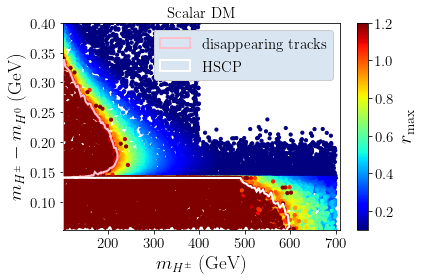

In [7]:
fig, ax = plt.subplots()
plt.scatter(df['mHc'],df['deltaM'],c=df['rmax'],alpha=1,cmap='jet',vmax=1.2,vmin=.1, s=10)
plt.scatter(compressed['mHc'],compressed['deltaM'],c=compressed['rmax'],alpha=1,cmap='jet',vmax=1.2,vmin=.1, s=10)
cb = plt.colorbar()
cb.set_label(label=r'$r_{\rm{max}}$', size = 20)
cb.ax.tick_params(labelsize=15)

###Disappearing tracks
frame_analysis2d=dt[['mHc','deltaM']]
frame_analysis2d=frame_analysis2d.to_numpy()
alpha_shape = alphashape.alphashape(frame_analysis2d, .001)
ax.add_patch(PolygonPatch(alpha_shape, alpha=1,ec='pink',fill=False,zorder=20,lw=2,label='disappearing tracks'))

####HSCP
frame_analysis2d=hscp[['mHc','deltaM']]
frame_analysis2d=frame_analysis2d.to_numpy()
alpha_shape = alphashape.alphashape(frame_analysis2d, .001)
ax.add_patch(PolygonPatch(alpha_shape, alpha=1,ec='white',fill=False,zorder=20,lw=2,label='HSCP'))

lgd = plt.legend(loc='upper right', facecolor='#d9e6f2', framealpha = 1., fontsize = 15),

# plt.text(200, 0.1, "HSCP exclusion", color='white', fontsize=15, ha='left', va='center')
# plt.annotate(xy=(150, 0.2), xytext=(405, 0.35), s="disappearing tracks\nexclusion", color='black', fontsize=15,
#              arrowprops={'arrowstyle':'->'}, ha='left', va='center')

ax.set_ylim(0.053,0.4)
ax.set_xlim(101,710)
# plt.yscale('log')
# plt.title(r"Scalar dark matter, $\mathregular{H^\pm \to (\pi^\pm\;\rm{or}\;ff') H^0}$",fontsize = 15)
plt.ylabel(r'$m_{H^\pm} - m_{H^0}$ (GeV)',fontsize = 19)
plt.xlabel(r'$m_{H^\pm}$ (GeV)',fontsize = 19)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplots_adjust(bottom=.13)
plt.subplots_adjust(left=.13)
plt.title('Scalar DM', fontsize = 15)
plt.tight_layout()

/home/lessa/.local/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


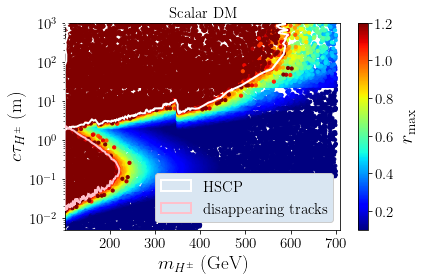

In [8]:
fig, ax = plt.subplots()
plt.scatter(df['mHc'],df['dHc'],c=df['rmax'],alpha=1,cmap='jet',vmax=1.2,vmin=.1, s=10)
plt.scatter(compressed['mHc'],compressed['dHc'],c=compressed['rmax'],alpha=1,cmap='jet',vmax=1.2,vmin=.1, s=10)
cb = plt.colorbar()
cb.set_label(label=r'$r_{\rm{max}}$', size = 20)
cb.ax.tick_params(labelsize=15)

####HSCP
frame_analysis2d=hscp[['mHc','dHc']]
frame_analysis2d=frame_analysis2d.to_numpy()
# Function for varying the alpha parameter
def alf(ind, r):
    if any(frame_analysis2d[ind][:,0] < 200) and any(frame_analysis2d[ind][:,1] < 7):
        return .05
#     elif any(frame_analysis2d[ind][:,0] < 280) and any(frame_analysis2d[ind][:,1] < 10):
#         return .0002
    elif any(frame_analysis2d[ind][:,0] < 380) and any(frame_analysis2d[ind][:,1] < 10):
        return .3
    else:
        return .008

alpha_shape = alphashape.alphashape(frame_analysis2d, alf)
ax.add_patch(PolygonPatch(alpha_shape, alpha=1,ec='white',fill=False,zorder=20,lw=2,label='HSCP'))

####Disappearing tracks
frame_analysis2d=dt[['mHc','dHc']]
frame_analysis2d=frame_analysis2d.to_numpy()
alpha_shape = alphashape.alphashape(frame_analysis2d, .01)
ax.add_patch(PolygonPatch(alpha_shape, alpha=1,ec='pink',fill=False,zorder=20,lw=2,label='disappearing tracks'))


lgd = plt.legend(loc='lower right', facecolor='#d9e6f2', framealpha = 1., fontsize = 15)

# plt.text(175, 100, "HSCP exclusion", color='white', fontsize=15, ha='left', va='center')
# plt.annotate(xy=(150, 0.1), xytext=(300, 0.7), s="disappearing tracks\nexclusion", color='white', fontsize=15,
#              arrowprops={'arrowstyle':'->', 'color':'white'}, ha='left', va='center')

ax.set_ylim(5e-3,1e3)
ax.set_xlim(101,710)
plt.yscale('log')
# plt.title(r"Scalar dark matter, $\mathregular{H^\pm \to (\pi^\pm\;\rm{or}\;ff') H^0}$",fontsize = 25)
plt.ylabel(r'$c\tau_{H^\pm}$ (m)',fontsize = 19)
plt.xlabel(r'$m_{H^\pm}$ (GeV)',fontsize = 19)
plt.title('Scalar DM', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplots_adjust(bottom=.13)
plt.subplots_adjust(left=.13)
plt.tight_layout()

In [9]:
# fig, ax = plt.subplots()
# # plt.scatter(hscp['mHc'], hscp['dHc'],s=20, color='grey', alpha=0.2)
# ax = plt.gca()
# # plt.scatter(atlas['mHc'], atlas['dHc'], label=r"ATLAS-SUSY-2016-06 scalar eff.", s=20, color='orange')
# # plt.scatter(cms['mHc'], cms['dHc'], label=r"CMS-EXO-19-010 fermions eff.", s=20, alpha = 0.2, color='C0')
# # plt.scatter(atlasf['mHc'], atlasf['dHc'], label=r"ATLAS-SUSY-2016-06 fermion eff.", s=20, color='red', alpha=0.15)

# frame_analysis2d=hscp[['mHc','dHc']]
# frame_analysis2d=frame_analysis2d.to_numpy()
# alphaHscp = alphashape.alphashape(frame_analysis2d, alf)

# frame_analysis2d=atlas[['mHc','dHc']]
# frame_analysis2d=frame_analysis2d.to_numpy()
# alphaAtlas = alphashape.alphashape(frame_analysis2d, .0005)

# frame_analysis2d=atlasf[['mHc','dHc']]
# frame_analysis2d=frame_analysis2d.to_numpy()
# alphaFatlas = alphashape.alphashape(frame_analysis2d, .0005)

# frame_analysis2d=cms[['mHc','dHc']]
# frame_analysis2d=frame_analysis2d.to_numpy()
# alphaCms = alphashape.alphashape(frame_analysis2d, .0005)

# ax.add_patch(PolygonPatch(alphaHscp, alpha=.5,fc='grey',ls='--',fill=True,zorder=20,lw=3, label='HSCP'))
# ax.add_patch(PolygonPatch(alphaCms,fc=(31/255,119/255,180/255,0.5),ec=(31/255,119/255,180/255,1.),fill=True,zorder=20,lw=3,label='CMS fermion eff.'))
# ax.add_patch(PolygonPatch(alphaAtlas, alpha=1,ec='orange',fc='orange',fill=True,zorder=20,lw=3,label='ATLAS scalar eff.'))
# ax.add_patch(PolygonPatch(alphaFatlas, alpha=1,ec='red',fc='red',fill=True,zorder=20,lw=3,label='ATLAS fermion eff.'))
# ax.add_patch(PolygonPatch(alphaCms, alpha=1,ec='C0',fc='C0',fill=False,zorder=20,lw=3))

# oldhandles, oldlabels = ax.get_legend_handles_labels()
# handles = oldhandles[1:]
# handles.append(oldhandles[0])
# labels = oldlabels[1:]
# labels.append(oldlabels[0])
# lgd = plt.legend(handles, labels, loc='lower right', framealpha=1.,fontsize=12)
# # for lh in lgd.legendHandles:
# #     lh.set_alpha(1)

# plt.ylim(1E-2,1E2)
# plt.xlim(100,500)
# plt.yscale('log')
# # plt.title(r"Scalar dark matter, $\mathregular{H^\pm \to (\pi^\pm\;\rm{or}\;ff') H^0}$",fontsize = 15)
# plt.ylabel(r'$c\tau_{H^\pm}$ (m)',fontsize = 19)
# plt.xlabel(r'$m_{H^\pm}$ (GeV)',fontsize = 19)
# plt.title('Scalar DM', fontsize = 15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.subplots_adjust(bottom=.13)
# plt.subplots_adjust(left=.13)
# plt.tight_layout()